### Importing dependencies

In [1]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
means = [0.43766510486602783, 0.49804747104644775, 0.3756938874721527]
stds = [0.16779577732086182, 0.1552586406469345, 0.1632111817598343]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(32,32)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(32,32)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(32,32)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [4]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the VGG16 Model Architecture

In [5]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Omitting some max-pooling to handle smaller input size
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Adjusting the size for Linear layer according to the output of the last pooling layer
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## Perform a sanity check for the correctness of the model

In [6]:
net = VGG16()
net = net.to(device)
data = torch.randn(5,3,32,32)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

### Move data and the model to the GPU

In [7]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Wed Apr 24 05:31:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              32W /  70W |    295MiB / 15360MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [8]:
# hyperparameters
INITIAL_LR = 0.005 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [9]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'VGG16.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.3813, Training accuracy: 0.2949


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3706, Validation accuracy: 0.3122
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 1.3640, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3582, Validation accuracy: 0.3122

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 1.3544, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3519, Validation accuracy: 0.3122

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 1.3493, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3439, Validation accuracy: 0.3122

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 1.3477, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3443, Validation accuracy: 0.3122

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 1.3468, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3443, Validation accuracy: 0.3122

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 1.3460, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3459, Validation accuracy: 0.3122

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 1.3458, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3447, Validation accuracy: 0.3122

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 1.3453, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3455, Validation accuracy: 0.3122

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 1.3458, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3452, Validation accuracy: 0.3122

Current learning rate has decayed to 0.005000
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 1.3448, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3459, Validation accuracy: 0.3122

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 1.3446, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3456, Validation accuracy: 0.3122

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 1.3443, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3413, Validation accuracy: 0.3122

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 1.3431, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3393, Validation accuracy: 0.3122

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 1.3413, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3431, Validation accuracy: 0.3122

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 1.3387, Training accuracy: 0.3119


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3328, Validation accuracy: 0.3122

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 1.3315, Training accuracy: 0.3823


validating...: 0it [00:00, ?it/s]

Validation loss: 1.3205, Validation accuracy: 0.4988
Saving ...

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 1.3005, Training accuracy: 0.4686


validating...: 0it [00:00, ?it/s]

Validation loss: 1.2485, Validation accuracy: 0.3624

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 1.1851, Training accuracy: 0.4311


validating...: 0it [00:00, ?it/s]

Validation loss: 1.0691, Validation accuracy: 0.5383
Saving ...

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 1.0032, Training accuracy: 0.5328


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9512, Validation accuracy: 0.5311

Current learning rate has decayed to 0.005000
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.9068, Training accuracy: 0.5471


validating...: 0it [00:00, ?it/s]

Validation loss: 0.8504, Validation accuracy: 0.5538
Saving ...

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.8205, Training accuracy: 0.5713


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7714, Validation accuracy: 0.7428
Saving ...

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.6965, Training accuracy: 0.7283


validating...: 0it [00:00, ?it/s]

Validation loss: 0.6039, Validation accuracy: 0.7679
Saving ...

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.5656, Training accuracy: 0.7734


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5743, Validation accuracy: 0.7763
Saving ...

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.5322, Training accuracy: 0.7901


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5549, Validation accuracy: 0.7871
Saving ...

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.5004, Training accuracy: 0.7997


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5267, Validation accuracy: 0.7919
Saving ...

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.4936, Training accuracy: 0.7969


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5208, Validation accuracy: 0.7883

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.4741, Training accuracy: 0.8092


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5106, Validation accuracy: 0.7967
Saving ...

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.4500, Training accuracy: 0.8147


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5056, Validation accuracy: 0.8038
Saving ...

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.4389, Training accuracy: 0.8150


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5100, Validation accuracy: 0.8074
Saving ...

Optimization finished: best validation accuracy is 0.8074


### Show the plots of the training and validation losses

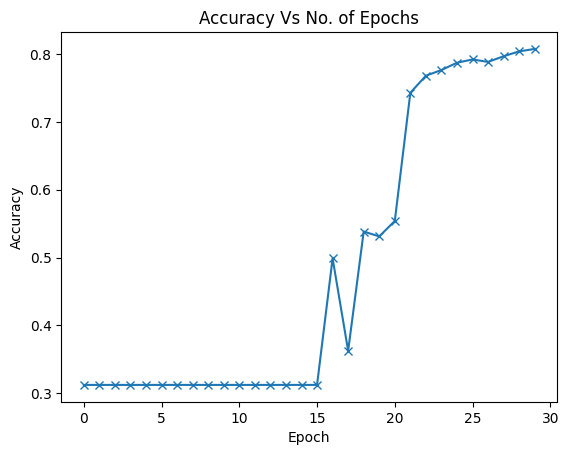

In [10]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

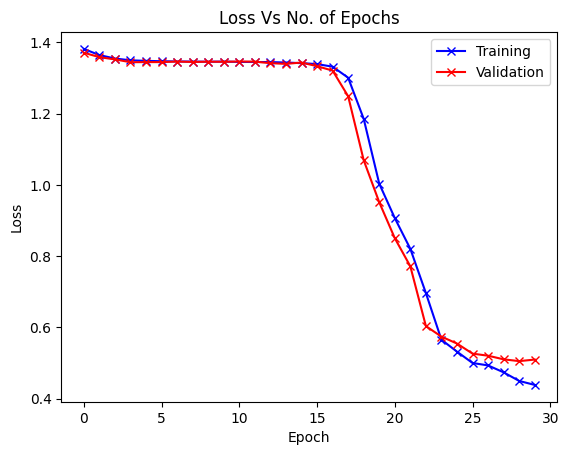

In [11]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

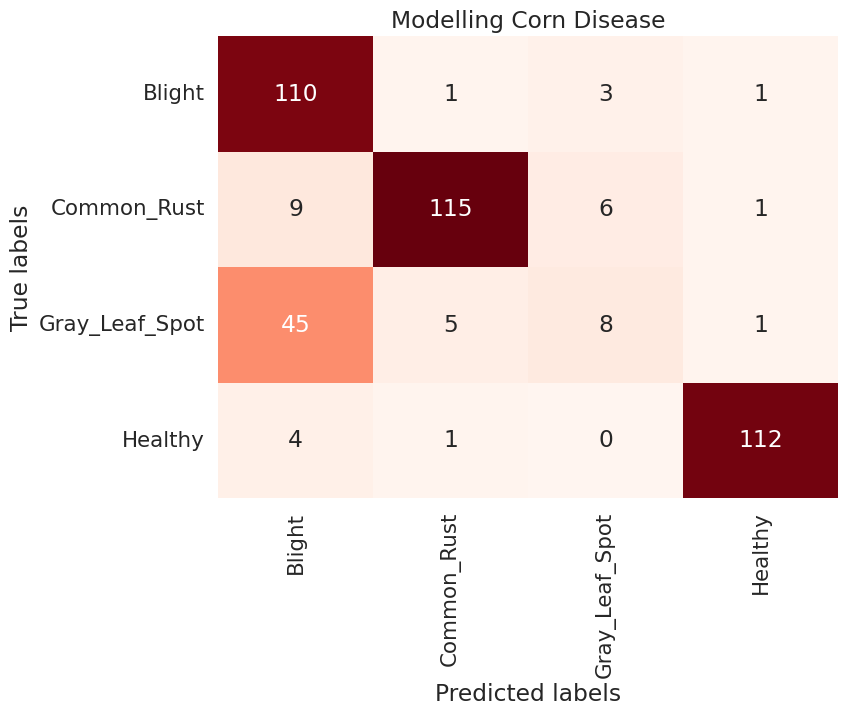

In [12]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

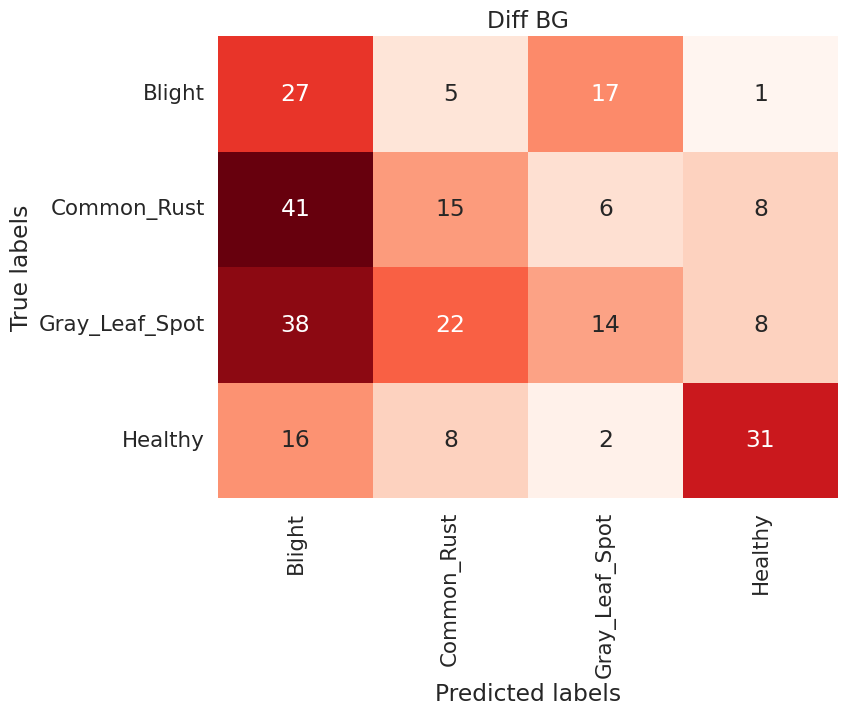

In [13]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()